In [33]:
import spikeforest as sf
import spikeinterface.full as si
import spikeinterface.widgets as sw
import matplotlib.pyplot as plt
import numpy as np
!pip install ipympl
%matplotlib widget

In [3]:
study_name = "paired_mea64c"
recording_name = "20170622_patch2"
uri = "sha1://1d343ed7e876ffd73bd8e0daf3b8a2c4265b783c?spikeforest-recordings.json"

You need to have set up kachery-cloud

In [77]:
all_recordings = sf.load_spikeforest_recordings(uri)
dataset_raw = [R for R in all_recordings if R.study_name == study_name and R.recording_name == recording_name][0]
recording = dataset_raw.get_recording_extractor().channel_slice([18])
sorting = dataset_raw.get_sorting_true_extractor()

Loading file from kachery cloud: sha1://1d343ed7e876ffd73bd8e0daf3b8a2c4265b783c?spikeforest-recordings.json
Loading file from kachery cloud: sha1://8cf175ddeccafebef4a1244521d4ae16386cb495?label=raw.mda
Loading file from kachery cloud: sha1://a1d7718979fcc1e3e1cb2df8f37486758dcd58ff?label=firings_true.mda


In [78]:
recording.is_filtered()

False

In [89]:
def fft_rec(rec):    
    tr = rec.get_traces(end_frame=100000)
    fs = rec.get_sampling_frequency()
    print(fs)
    t = np.arange(0,100000)/fs
    
    # Perform FFT
    fft_result = np.fft.fft(tr)[:len(tr)//2]
    frequencies = np.fft.fftfreq(len(tr), 1/fs)[:len(tr)//2]
    
    # Plot the original signal and its frequency domain representation
    plt.figure(figsize=(13, 7))
    plt.subplot(2, 1, 1)
    plt.plot(t, tr)
    plt.title('Original Signal')
    
    plt.subplot(2, 1, 2)
    plt.plot(frequencies, np.abs(fft_result))
    plt.title('Frequency Domain Representation')
    plt.xlabel('Frequency (Hz)')
    plt.xlim(0, 6000)
    
    plt.tight_layout()
    plt.show()

20000.0


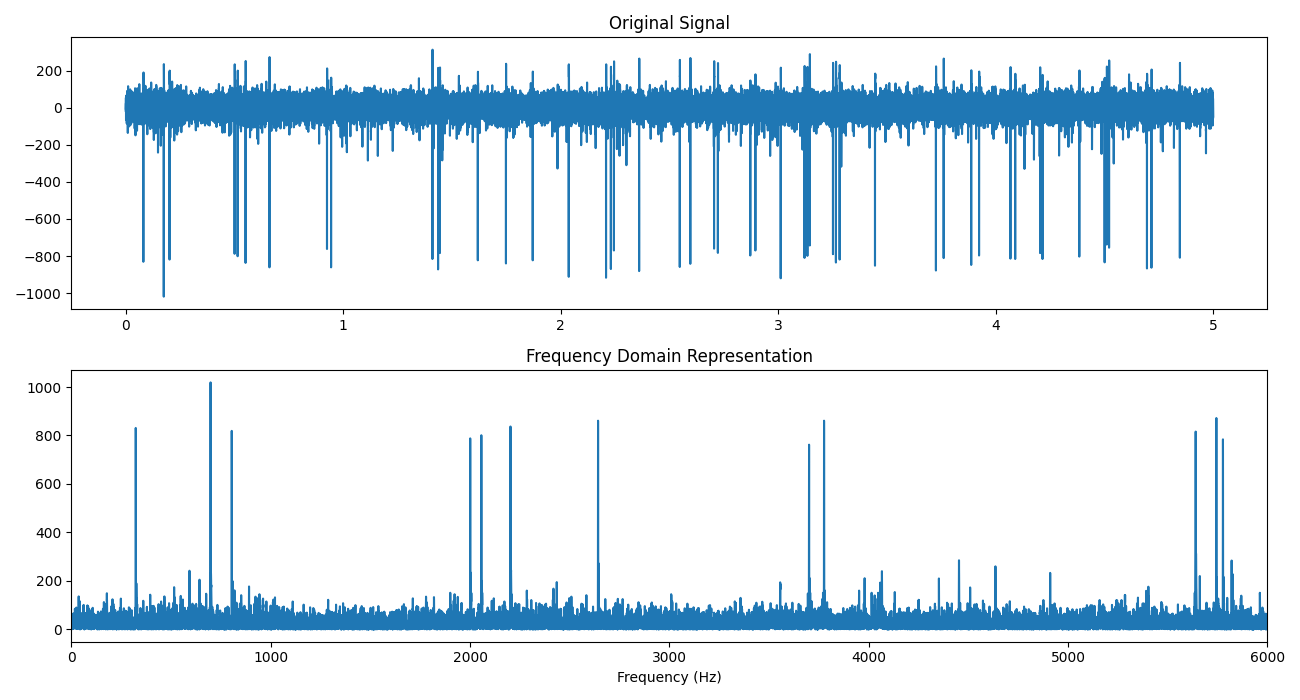

In [90]:
fft_rec(recording)

20000.0


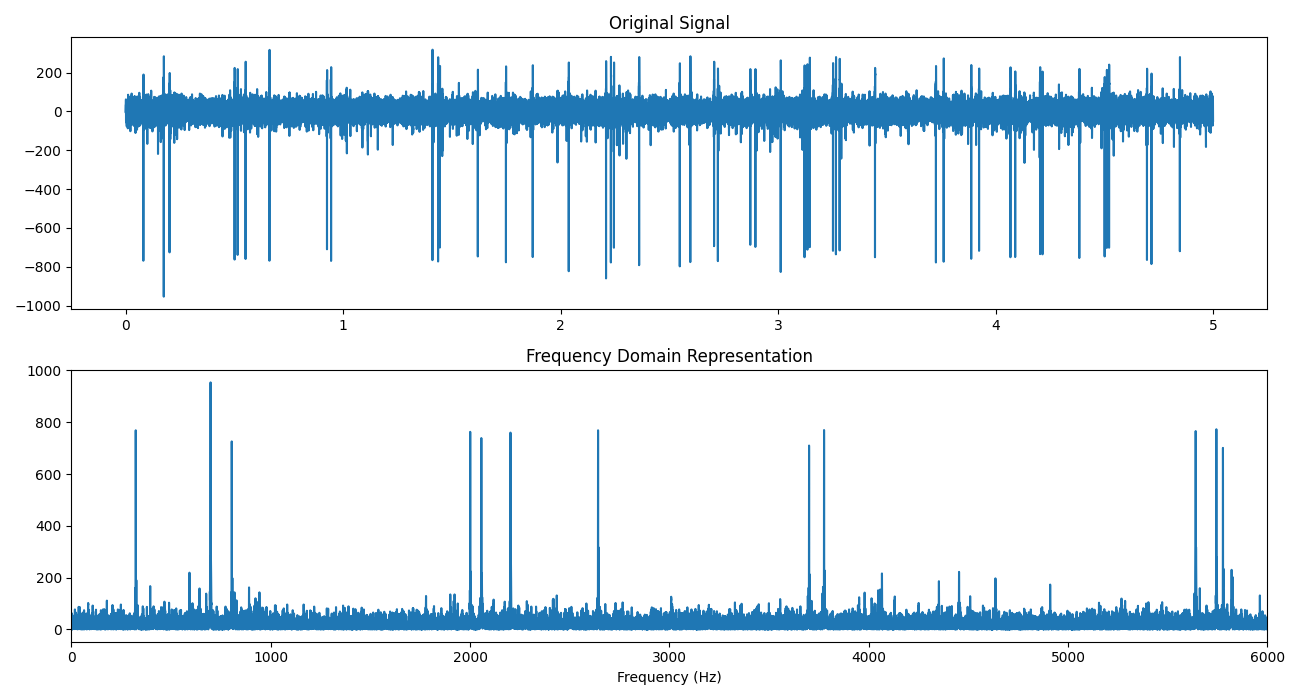

In [91]:
recording_filt = si.bandpass_filter(recording, 300, 6000)
fft_rec(recording_filt)

In [6]:
sw.plot_traces(recording, time_range=[0, 10], backend='ipywidgets')

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

In [11]:

waveforms = si.extract_waveforms(recording, sorting, max_spikes_per_unit=2500, mode="memory")
w = sw.plot_spikes_on_traces(recording=recording, backend="matplotlib")

TypeError: __init__() missing 1 required positional argument: 'waveform_extractor'